In [27]:
import sim
import matplotlib.patches as patches
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import numpy as np





%pylab inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


In [28]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    res, position = sim.simxGetObjectOrientation(clientID, cuboid, -1, sim.simx_opmode_blocking)  
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  102051
Omnirob is at [x,y,z]= [-6.8592780735343695e-06, -0.00024003844009712338, -1.570927381515503]
Disconnected


## Potential functions

In [29]:
# Potential functions
def force_goal(x, y, goal):
    goal_x, goal_y, k_goal = goal
    Fx_goal, Fy_goal = k_goal * (goal_x - x), k_goal *(goal_y - y)
    return Fx_goal, Fy_goal

def force_obstacle(x, y, obstacle):
    (obs_x, obs_y, k_obs) = obstacle
    dist_x, dist_y = x - obs_x, y - obs_y
    dist_obs = np.hypot(dist_x, dist_y)
    Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
    Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3

    return Fx_obs, Fy_obs 

def total_force(x, y, goal, obstacles):
    Fx, Fy = force_goal(x, y, goal)

    for obs in obstacles:
        Fo_x, Fo_y = force_obstacle(x, y, obs)
        Fx += Fo_x
        Fy += Fo_y
    return Fx, Fy


### Rotation matrix

In [30]:
def Rotz(Θ):
    R = array([[cos(Θ), -sin(Θ),0], [sin(Θ), cos(Θ),0],[0,0,1]])
    return R

In [31]:
def plot_vector_field(ax=plt, fmax = 2):
    X, Y = np.meshgrid(np.arange(-10, 10, .5), np.arange(-10, 10, .5))

    # Vector field of the forces
    Fx, Fy = total_force(X, Y, goal, obstacles)

    # For visualization
    F_m = np.hypot(Fx, Fy)
    Fx[F_m > fmax], Fy[F_m > fmax] = None, None
    # Plot
    # quiver(X, Y, Fx, Fy,  F_m, color='0.4', scale=None)
#     ax.quiver(X, Y, Fx, Fy, color='0.4')
    
    return X, Y, Fx, Fy
    
def simulate(q, goal, obstacles, num_steps=200, delta_time=1.9):
    trajectory = []
    for i in range(num_steps):
        force = total_force(q[0], q[1], goal, obstacles)
        # Robot velocity follows the force vector
        vel = np.array(force)
        # Integrate
        q += vel * delta_time
        trajectory.append(np.copy(q))

    
    return np.array(trajectory)   

In [32]:
# Plot the grid
def draw_grid(grid):
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['0.9', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, cmap=cmap, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, m, 1));
    ax.set_yticks(np.arange(-0.5, n, 1));

In [33]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)

    def get_orientation(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(euler)    
     
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

# Scenario discretization 

Robot connected
[ 1.45600570e-04 -1.91966072e-04 -8.72819543e-01]
[[0 0]
 [1 1]
 [2 2]
 [3 3]]


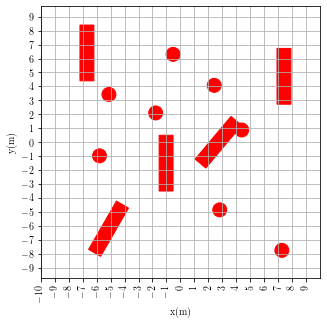

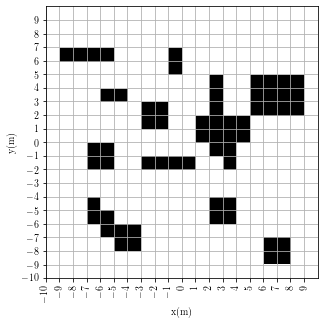

In [34]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

q1 = r.get_object_position('Omnirob')

g1 = r.get_object_position('Sphere9')

p1 = r.get_object_position('Cylinder5')
p2 = r.get_object_position('Cylinder6')
p3 = r.get_object_position('Cylinder7')
p4 = r.get_object_position('Cylinder8')
p5 = r.get_object_position('Cylinder9')
p6 = r.get_object_position('Cylinder10')
p7 = r.get_object_position('Cylinder11')
p8 = r.get_object_position('Cylinder12')

c1 = r.get_object_position('Cuboid0')
c2 = r.get_object_position('Cuboid1')
c3 = r.get_object_position('Cuboid3')
c4 = r.get_object_position('Cuboid4')
c5 = r.get_object_position('Cuboid6')
oc1 = r.get_orientation('Cuboid0')
oc2 = r.get_orientation('Cuboid1')
oc3 = r.get_orientation('Cuboid3')
oc4 = r.get_orientation('Cuboid4')
oc5 = r.get_orientation('Cuboid6')


print(oc1)

# circleq1 = plt.Circle((q1[0], q1[1]), 0.5, color='g')
# circleg1 = plt.Circle((g1[0], g1[1]), 0.5, color='r')

circle1 = plt.Circle((p1[0], p1[1]), 0.5, color='r')
circle2 = plt.Circle((p2[0], p2[1]), 0.5, color='r')
circle3 = plt.Circle((p3[0], p3[1]), 0.5, color='r')
circle4 = plt.Circle((p4[0], p4[1]), 0.5, color='r')
circle5 = plt.Circle((p5[0], p5[1]), 0.5, color='r')
circle6 = plt.Circle((p6[0], p6[1]), 0.5, color='r')
circle7 = plt.Circle((p7[0], p7[1]), 0.5, color='r')
circle8 = plt.Circle((p8[0], p8[1]), 0.5, color='r')

# Rectangle1 = plt.Rectangle((c1, c1),4,1, color='k')

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(5, 5))

# ax.add_artist(circleq1)
# ax.add_artist(circleg1)

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(circle5)
ax.add_artist(circle6)
ax.add_artist(circle7)
ax.add_artist(circle8)

# ax.add_patch(patches.Rectangle((c1, c1),4,1,edgecolor = 'black',facecolor = 'black',fill=True))

# ax.add_artist(Rectangle1)

c = [-2, -0.5, 0]

delta_x1 = Rotz(-oc1[2]).dot(c)
c1 += delta_x1
ax.add_patch( Rectangle((c1[0], c1[1]), 4, 1, angle=(-oc1[2])*180/pi, color='r')) 

delta_x2 = Rotz(-oc2[2]).dot(c)
c2 += delta_x2
ax.add_patch( Rectangle((c2[0], c2[1]), 4, 1, angle=(-oc2[2])*180/pi, color='r')) 

delta_x3 = Rotz(-oc3[2]).dot(c)
c3 += delta_x3
ax.add_patch( Rectangle((c3[0], c3[1]), 4, 1, angle=(-oc3[2])*180/pi, color='r')) 

delta_x4 = Rotz(-oc4[2]).dot(c)
c4 += delta_x4
ax.add_patch( Rectangle((c4[0], c4[1]), 4, 1, angle=(-oc4[2])*180/pi, color='r')) 

delta_x5 = Rotz(-oc5[2]).dot(c)
c5 += delta_x5
ax.add_patch( Rectangle((c5[0], c5[1]), 4, 1, angle=(-oc5[2])*180/pi, color='r')) 


xlabel('x(m)')
ylabel('y(m)')
ax.set_xticks(numpy.arange(-10, 10, 1))
ax.set_yticks(numpy.arange(-10, 10, 1))
ax.grid(True)
ax.axis('equal')
ax.axis([-10., 10., -10., 10.])

fig.savefig('exp_e1.pdf', bbox_inches="tight")


points = array([
    [0, 0],
    [1, 1],
    [2, 2],
    [3, 3]])

print(points)
check = np.zeros((20, 20))
check[3:4,1:5] = check[5:8,15:19] = check[11:12,7:11] =  1
check[8:10,11] = check[7:11,12] = check[10:12,13] = 1
check[14:16,3] = check[15:17,4] = check[16:18,5:7] = 1

check[3:5,9] = check[5:7,12] = check[6,4:6] = check[7:9,7:9] = check[10:12,3:5] = 1
check[14:16,12:14] = check[17:19,16:18] = check[8:10,13:15] = 1

# print(check)
xticks(rotation=90)

fig.savefig('exp_e31a.pdf', bbox_inches="tight")


# fig, ax = plt.subplots(figsize=(5, 5))

# implot = np.zeros((20, 20))
# implot[check == 0] = 2
# implot[check == 1] = 0

# imshow(implot, extent=[-10, 10., -10., 9.85] , cmap='gray') 

# xlabel('x(m)')
# ylabel('y(m)')
# ax.set_xticks(numpy.arange(-10, 10, 1))
# ax.set_yticks(numpy.arange(-10, 10, 1))
# ax.grid(True)
# # ax.axis('equal')
# ax.axis([-10., 10, -10., 10])
# xticks(rotation=90)

# fig.savefig('exp_e1.pdf', bbox_inches="tight")

# # ax.imshow(check, cmap='gray', interpolation='nearest')

# fig.savefig('exp_e31b.pdf', bbox_inches="tight")

# # print(check)

# Potential fiels algorithm 

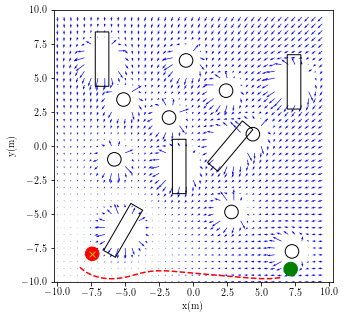

In [35]:

q1 = r.get_object_position('Omnirob')

g1 = r.get_object_position('Sphere9')

p1 = r.get_object_position('Cylinder5')
p2 = r.get_object_position('Cylinder6')
p3 = r.get_object_position('Cylinder7')
p4 = r.get_object_position('Cylinder8')
p5 = r.get_object_position('Cylinder9')
p6 = r.get_object_position('Cylinder10')
p7 = r.get_object_position('Cylinder11')
p8 = r.get_object_position('Cylinder12')

c1 = r.get_object_position('Cuboid0')
c2 = r.get_object_position('Cuboid1')
c3 = r.get_object_position('Cuboid3')
c4 = r.get_object_position('Cuboid4')
c5 = r.get_object_position('Cuboid6')
oc1 = r.get_orientation('Cuboid0')
oc2 = r.get_orientation('Cuboid1')
oc3 = r.get_orientation('Cuboid3')
oc4 = r.get_orientation('Cuboid4')
oc5 = r.get_orientation('Cuboid6')

# Goal
goal = [g1[0], g1[1], 0.05]

# Obstacles (x, y, k), where k is the rejection multiplier
k = 1.5
k2 = 4
obstacles = [[p1[0], p1[1], k],
             [p2[0], p2[1], k],
             [p3[0], p3[1], k],
             [p4[0], p4[1], k],
             [p5[0], p5[1], k],
             [p6[0], p6[1], k],
             [p7[0], p7[1], k],
             [p8[0], p8[1], k],
             [c1[0], c1[1], k2],
             [c2[0], c2[1], k2],
             [c3[0], c3[1], k2],
             [c4[0], c4[1], k2],
             [c5[0], c5[1], k2],
              ]

# Initial location
q = np.array((q1[0], q1[1]))


fig, ax = plt.subplots(figsize=(5, 5))

# Shoe result
trajectory = simulate(q, goal, obstacles,num_steps=220, delta_time=1.)

plot(trajectory[:,0], trajectory[:,1], 'r--')
plot(goal[0], goal[1], 'yx')
X, Y, Fx, Fy = plot_vector_field()

ax.quiver(X, Y, Fx, Fy, color='blue')
# hold

ax.add_patch(mpl.patches.Circle((q1[0], q1[1]), 0.5, color='g'))
ax.add_patch(mpl.patches.Circle((g1[0], g1[1]), 0.5, color='r'))

ax.add_patch(mpl.patches.Circle((p1[0], p1[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p2[0], p2[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p3[0], p3[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p4[0], p4[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p5[0], p5[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p6[0], p6[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p7[0], p7[1]), 0.5, color='k', fill=False))
ax.add_patch(mpl.patches.Circle((p8[0], p8[1]), 0.5, color='k', fill=False))

c = [-2, -0.5, 0]

delta_x1 = Rotz(-oc1[2]).dot(c)
c1 += delta_x1
ax.add_patch( Rectangle((c1[0], c1[1]), 4, 1, angle=(-oc1[2])*180/pi, color='k', fill=False)) 

delta_x2 = Rotz(-oc2[2]).dot(c)
c2 += delta_x2
ax.add_patch( Rectangle((c2[0], c2[1]), 4, 1, angle=(-oc2[2])*180/pi, color='k', fill=False)) 

delta_x3 = Rotz(-oc3[2]).dot(c)
c3 += delta_x3
ax.add_patch( Rectangle((c3[0], c3[1]), 4, 1, angle=(-oc3[2])*180/pi, color='k', fill=False)) 

delta_x4 = Rotz(-oc4[2]).dot(c)
c4 += delta_x4
ax.add_patch( Rectangle((c4[0], c4[1]), 4, 1, angle=(-oc4[2])*180/pi, color='k', fill=False)) 

delta_x5 = Rotz(-oc5[2]).dot(c)
c5 += delta_x5
ax.add_patch( Rectangle((c5[0], c5[1]), 4, 1, angle=(-oc5[2])*180/pi, color='k', fill=False)) 


xlabel('x(m)')
ylabel('y(m)')

ax.axis('equal')
ax.axis([-10, 10, -10, 10])

fig.savefig('exp_e41.pdf', bbox_inches="tight")

# Simulation potential fields

In [38]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot


q1 = r.get_object_position('Omnirob')

g1 = r.get_object_position('Sphere9')

p1 = r.get_object_position('Cylinder5')
p2 = r.get_object_position('Cylinder6')
p3 = r.get_object_position('Cylinder7')
p4 = r.get_object_position('Cylinder8')
p5 = r.get_object_position('Cylinder9')
p6 = r.get_object_position('Cylinder10')
p7 = r.get_object_position('Cylinder11')
p8 = r.get_object_position('Cylinder12')

c1 = r.get_object_position('Cuboid0')
c2 = r.get_object_position('Cuboid1')
c3 = r.get_object_position('Cuboid3')
c4 = r.get_object_position('Cuboid4')
c5 = r.get_object_position('Cuboid6')
oc1 = r.get_orientation('Cuboid0')
oc2 = r.get_orientation('Cuboid1')
oc3 = r.get_orientation('Cuboid3')
oc4 = r.get_orientation('Cuboid4')
oc5 = r.get_orientation('Cuboid6')

# Goal
goal = [g1[0], g1[1], 0.05]

# Obstacles (x, y, k), where k is the rejection multiplier
k = 1.5
k2 = 4
obstacles = [[p1[0], p1[1], k],
             [p2[0], p2[1], k],
             [p3[0], p3[1], k],
             [p4[0], p4[1], k],
             [p5[0], p5[1], k],
             [p6[0], p6[1], k],
             [p7[0], p7[1], k],
             [p8[0], p8[1], k],
             [c1[0], c1[1], k2],
             [c2[0], c2[1], k2],
             [c3[0], c3[1], k2],
             [c4[0], c4[1], k2],
             [c5[0], c5[1], k2],
              ]


l = 0.347
w = 0.238
ra = 0.040

A = 1/ra*array([[-l-w, 1, -1],
           [l+w, 1, -1],
           [l+w, 1, 1],
           [-l-w, 1, 1]])

# Initial location

print(q)

trajectory = []
num_steps=2000
delta_time=1.9

while(True):
    q1 = r.get_object_position('Omnirob')
    q = np.array((q1[0], q1[1]))
    
    force = total_force(q[0], q[1], goal, obstacles)
    # Robot velocity follows the force vector
    vel = np.array(force)
    vx, vy = vel

    r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
    pause(0.05)
        
print('end')


Robot connected
[ 7.55302715 -9.77039909]


KeyboardInterrupt: 

In [ ]:
r.send_motor_velocities([0, 0, 0, 0])
r.close_connection()  # End